# Skin Cancer Detection Using the ISIC Dataset

## Introduction

This notebook demonstrates the process of developing a deep learning model for skin cancer detection using the **ISIC (International Skin Imaging Collaboration)** dataset. The ISIC dataset is a renowned benchmark for medical image analysis, providing high-quality images of skin lesions along with detailed annotations.

### Objectives
- Preprocess the ISIC dataset for deep learning tasks.
- Build, train, and evaluate a deep learning model for classifying skin lesions.
- Optimize the model to achieve high accuracy and robustness.

### Workflow
1. **Data Loading and Preprocessing**: Load the ISIC dataset, handle missing or inconsistent data, and preprocess the images for model input.
2. **Model Development**: Design and train a Convolutional Neural Network (CNN) for skin lesion classification.
3. **Evaluation and Optimization**: Evaluate the model's performance and fine-tune hyperparameters for better accuracy.

### Tools and Libraries
- **Python**: Programming language for data science and machine learning.
- **PyTorch**: Deep learning framework for building and training the model.
- **Matplotlib**: Library for data visualization.
- **Pandas**: Tool for data manipulation.

> **Note**: This project is part of an effort to leverage AI for advancing healthcare and improving early detection of skin cancer.


In [2]:
import os

os.environ["KAGGLE_USERNAME"] = "mohammeds3d"
os.environ["KAGGLE_KEY"] = (
    "2b004b125edec969d6964140c147aea7"  # don't abuse it please (e.g. don't run the next cell billions of times)
)

import kaggle

## Downloading the ISIC Dataset


1. **Download the Dataset**: Utilizes the Kaggle API to download the dataset for the ISIC 2024 Challenge into the `data` directory.
2. **Extract the Dataset**: Unzips the downloaded file into the `data` directory.
3. **Clean Up**: Removes the zip file to save disk space after extraction.

This ensures the dataset is readily available for preprocessing and model training without redundant downloads.


In [3]:
# Download the dataset
if os.path.exists("data"):
    print("Data already exists.")
else:
    kaggle.api.competition_download_files("isic-2024-challenge", path="data")
    import zipfile

    with zipfile.ZipFile("data/isic-2024-challenge.zip", "r") as zip_ref:
        zip_ref.extractall("data")
    os.remove("data/isic-2024-challenge.zip")
    print("Data downloaded and extracted.")

Data downloaded and extracted.


## Setting Up the Environment

The following code initializes the environment for reproducibility and device configuration:


**Determine the Device**:  
   - The code checks for available hardware to maximize computational efficiency:  
     - Uses **CUDA** if a GPU is available.  
     - Falls back to **Metal Performance Shaders (MPS)** for macOS devices with GPU support.  
     - Defaults to **CPU** if no GPU is detected.  


This setup ensures efficient resource utilization and reproducibility in model training and evaluation.


In [5]:
import torch
import numpy as np

torch.manual_seed(471)
SEED = 471
# set device
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")

Using device: cuda


## Loading and Analyzing Metadata

The following code loads and preprocesses the dataset metadata for binary image classification:

1. **Load Metadata**:  
   - Reads the metadata file (`train-metadata.csv`) into a Pandas DataFrame.  
   - This file contains information about the images, including labels and other features.


2. **Class Distribution Analysis**:  
   - Calculates the normalized value counts of the `target` column.  
   - Provides insight into the percentage of each class (e.g., balanced or imbalanced dataset).  

This step helps us understand the structure and distribution of the dataset, which is crucial for effective model training and evaluation.


In [1]:
# metadata
import pandas as pd

metadata = pd.read_csv("data/train-metadata.csv")

# now, we are only interested in the image path and the target #TODO: consider using other features
# Doing only image binary classification
metadata = metadata[["isic_id", "target"]]

# check the statistics of the target, to see if it's balanced??
# perentage of each class

metadata["target"].value_counts(normalize=True)

C:\Users\akalh\AppData\Local\Temp\ipykernel_21448\1831821869.py:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("data/train-metadata.csv")


target
0    0.99902
1    0.00098
Name: proportion, dtype: float64

In [7]:
# okay, it's not balanced, with huge difference between the two classes! data augmentation? upsampling? downsampling? class weights?
# #TODO: consider using other techniques

## Custom Dataset Class for Image Classification

This code defines a custom dataset class compatible with PyTorch's `Dataset` API. It is designed for image classification tasks and works with datasets organized using metadata files.

### Key Features
- **Metadata Integration**: Uses a DataFrame to manage image paths and labels.  
- **Flexible Transformations**: Supports applying transformations (e.g., resizing, normalization) to the images during loading.  
- **PyTorch Compatibility**: Easily integrates with `DataLoader` for efficient data batching and shuffling.  

This class provides a reusable framework for handling image datasets in machine learning projects.


In [2]:
# custom dataset
from torch.utils.data import Dataset
from PIL import Image


class ISICDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform
        self.images = metadata["isic_id"]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = f"data/train-image/image/{self.metadata.iloc[idx, 0]}.jpg"
        image = Image.open(image_path)
        label = self.metadata.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

## Visualizing Sample Images from Each Class

In this section, we will visualize a few sample images from each class in the dataset (`target = 0` and `target = 1`) to get an overview of the data. The images will be displayed alongside their corresponding labels for quick inspection.


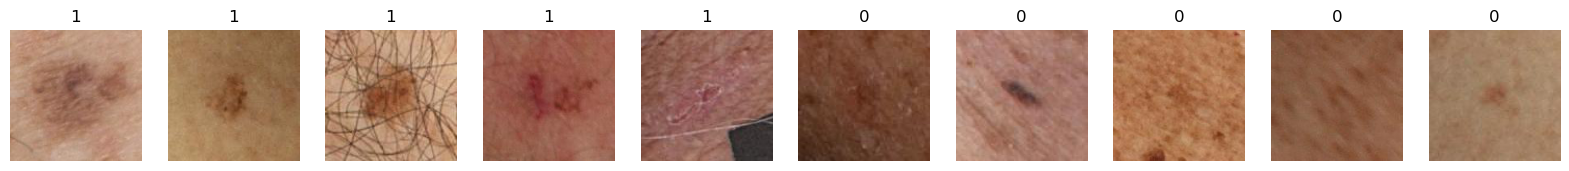

In [3]:
# display few images, for each class
import matplotlib.pyplot as plt

# get three random indices target = 0
indicesneg = metadata[metadata["target"] == 0].sample(5).index
# get three random indices target = 1
indicespos = metadata[metadata["target"] == 1].sample(5).index

fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(5):
    image, label = ISICDataset(metadata).__getitem__(indicespos[i])
    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis("off")
    image, label = ISICDataset(metadata).__getitem__(indicesneg[i])
    axes[i + 5].imshow(image)
    axes[i + 5].set_title(label)
    axes[i + 5].axis("off")
plt.show()

## Splitting the Data into Train and Test Sets

In this section, we split the dataset into training and testing sets with stratified sampling. 30% of the data is used for testing, ensuring an equal distribution of both classes. The remaining 70% is used for training, with a specific class distribution of 33% positive and 66% negative. We also check the class distribution in both sets to ensure proper balance.


In [6]:
# split the data into train and test first, make sure to stratify the split
# 30% test, 70% train, (50%, 50%  each class in the test)
from sklearn.model_selection import train_test_split

# take 30% of the data as test, 15% of each class
# choose random rows with target = 1. n = 393.
# 393 * 0.3 = 118

df_test = pd.concat(
    [
        metadata[metadata["target"] == 1].sample(118, random_state=SEED),
        metadata[metadata["target"] == 0].sample(118, random_state=SEED),
    ]
)
df_train = metadata.drop(df_test.index)  # drop the test indices

# now consider the rest of positive (393-118) = 275 and negative as well, make the class distribution 33% for the positive and 66% for the negative
# 275 and 550. TODO: consider other ratios, and the rest of the dataset.
df_train = pd.concat(
    [
        df_train[df_train["target"] == 1].sample(275, random_state=SEED),
        df_train[df_train["target"] == 0].sample(550, random_state=SEED),
    ]
)

# check the percentage of each class in the test
print("test")
print(df_test["target"].value_counts(normalize=True))
print(len(df_test))
print("train")
print(df_train["target"].value_counts(normalize=True))
print(len(df_train))

test
target
1    0.5
0    0.5
Name: proportion, dtype: float64
236
train
target
0    0.666667
1    0.333333
Name: proportion, dtype: float64
825


## Splitting Data into Train, Validation Sets, and Applying Transformations

In this section, we split the training data further into 85% training and 15% validation sets, maintaining class balance. We then apply transformations to the images:

1. **Data Augmentation**: For the training set, we use random horizontal flipping, rotations, and color jittering to increase the diversity of the data.
2. **Normalization**: Both training and validation sets are resized to 224x224 and normalized using standard ImageNet values.

Finally, we create PyTorch `DataLoader` instances for both the training and validation datasets, which will be used for efficient batch loading during model training.


In [7]:
# 15% validation, 70% train
df_train, df_val = train_test_split(
    df_train, test_size=0.15, stratify=df_train["target"], random_state=SEED
)
### transformations. TODO: consider using data augmentation techniques more often with the minority class! #NOTE: IMPORTANT
from torchvision import transforms

transform_train = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        # data augmentation. #NOTE: not considering the class imbalance here, consider using more data augmentation techniques with the minority class
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transform_val = transform_train = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# create the datasets
train_data = ISICDataset(df_train, transform=transform_train)
val_data = ISICDataset(df_val, transform=transform_val)

# create the dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

## Model Creation and Configuration

In this section, we define the model using one of four architectures: EfficientNet-B0, VGG16, ResNet50, or ResNet18. The model is then moved to the appropriate device (GPU or CPU) for training.

### Notes:
- We use `BCEWithLogitsLoss` as the loss function, so no sigmoid activation is required in the final layer.


In [8]:
# create the model
from torchvision import models
import torch.nn as nn

# directory to save the results, we are interested in (acc vs epoch), (loss vs epoch), (confusion matrix), (auc vs epoch). (same for test & val)
RESULTS_DIR = "results"
RESULTS = {}
# model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.IMAGENET1K_V1")
# freeze the parameters if
# for param in model.parameters():
#    param.requires_grad = False

# add few layers (efficientnet)
model = nn.Sequential(
    model,
    nn.ReLU(),
    nn.Linear(1000, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    # No need for sigmoid, as we will use BCEWithLogitsLoss
)


# move the model to the device
model = model.to(device)

## Loss Function and Optimizer

In this section, we define the loss function, optimizer, and learning rate scheduler for training the model.

- **Loss Function**: We use `BCEWithLogitsLoss` with a class balancing factor (`pos_weight`) to address the class imbalance in the dataset.
- **Optimizer**: We use the AdamW optimizer with a learning rate of `2e-4` and a weight decay of `1e-3`.
- **Learning Rate Scheduler**: A `StepLR` scheduler is applied, decreasing the learning rate by a factor of 0.1 every 5 epochs.




In [9]:
# loss function

# TODO: change these hyperparameters including the loss function, optimizer, learning rate, weight decay, etc.
from torch.nn import BCEWithLogitsLoss

loss_fn = BCEWithLogitsLoss(pos_weight=torch.tensor([2 / 1]).to(device))
# NOTE: pos_weight is used to balance the classes, as the dataset is imbalanced.

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-3)

epochs = 10

# learning rate scheduler
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# store the results
RESULTS["model"] = model.__str__()
RESULTS["optimizer"] = optimizer.__str__()
RESULTS["loss_fn"] = loss_fn.__str__()
RESULTS["Distribution"] = (
    train_data.metadata["target"].value_counts(normalize=True),
    val_data.metadata["target"].value_counts(normalize=True),
)

## Training Loop and Early Stopping

The training loop performs the following steps for each epoch:

1. **Training**:
   - The model is trained on the training dataset using backpropagation.
   - The loss is computed using `BCEWithLogitsLoss`, and gradients are updated with `optimizer.step()`.
   - The accuracy for each batch is computed by comparing the predicted labels to the actual labels.

2. **Validation**:
   - The model is evaluated on the validation dataset.
   - The validation loss and accuracy are computed similarly to the training phase.
   - The Area Under the Curve (AUC) score is calculated for each batch.

3. **Early Stopping**:
   - If the validation loss does not improve significantly (minimum change set to 0.01) over several epochs (patience = 3), early stopping is triggered to prevent overfitting.

4. **Results**:
   - Training and validation losses, accuracies, and AUC scores are tracked and printed at each epoch.
   - Results are saved for later analysis.

This setup allows the model to stop training early if improvements are minimal, ensuring efficient training.


In [10]:
# define the training loop
from sklearn.metrics import roc_auc_score  # auc

# for early stopping
best_val_loss = float("inf")
patience_counter = 0
minimum_change = 0.01
patience = 3


# ploting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
aucs = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    # training
    model.train()
    train_loss = 0
    train_acc = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.float().view(-1, 1).to(device)
        optimizer.zero_grad()

        output = model(inputs)

        loss = loss_fn(output, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # accuracy
        predicted = torch.sigmoid(output).round()
        train_acc += (predicted == labels).sum().item()

    # validation
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for batch_idx, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.float().view(-1, 1).to(
                device
            )

            output = model(vinputs)
            loss = loss_fn(output, vlabels)

            val_loss += loss.item()

            # accuracy
            predicted = torch.sigmoid(output).round()
            val_acc += (predicted == vlabels).sum().item()

            ##compute auc
            auc = roc_auc_score(vlabels.cpu().numpy(), output.cpu().numpy())

    # Step the scheduler
    scheduler.step()

    # print results
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    aucs.append(auc)

    print(
        f"Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}\n"
        + f"Val loss: {val_loss:.4f}, accuracy: {val_acc:.4f}\n"
        + f"Val AUC: {auc:.4f}"
    )

    # early stopping
    if best_val_loss - val_loss > minimum_change:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# save the results
RESULTS["train_losses"] = train_losses
RESULTS["val_losses"] = val_losses
RESULTS["train_accuracies"] = train_accuracies
RESULTS["val_accuracies"] = val_accuracies
RESULTS["aucs_epoch"] = aucs

Epoch 1
-------------------------------
Train loss: 0.9216, accuracy: 0.6377
Val loss: 0.9103, accuracy: 0.7661
Val AUC: 0.6122
Epoch 2
-------------------------------
Train loss: 0.8582, accuracy: 0.7475
Val loss: 0.6685, accuracy: 0.7339
Val AUC: 0.8776
Epoch 3
-------------------------------
Train loss: 0.5646, accuracy: 0.8245
Val loss: 0.5397, accuracy: 0.8629
Val AUC: 0.8776
Epoch 4
-------------------------------
Train loss: 0.2627, accuracy: 0.9258
Val loss: 0.6798, accuracy: 0.8226
Val AUC: 0.8571
Epoch 5
-------------------------------
Train loss: 0.1979, accuracy: 0.9415
Val loss: 0.8072, accuracy: 0.8145
Val AUC: 0.8844
Epoch 6
-------------------------------
Train loss: 0.1501, accuracy: 0.9429
Val loss: 0.7149, accuracy: 0.8306
Val AUC: 0.8980
Early stopping triggered


## Model Evaluation on Test Set

After training, the model is evaluated on the test set with the following steps:

1. **Test Data Preparation**:
   - A new dataset `test_dataset` is created from `df_test`, and a DataLoader `test_loader` is used to load the data in batches.

2. **Prediction**:
   - The model is set to evaluation mode using `model.eval()`.
   - Predictions are made for each batch by passing the test data through the model and applying the sigmoid function, followed by rounding to get binary labels.

3. **Metrics Calculation**:
   - **AUC (Area Under the Curve)** is computed using `roc_auc_score`.
   - **Confusion Matrix** is generated using `confusion_matrix`.
   - **Accuracy** is computed using `accuracy_score`.
   - **Recall** is computed using `recall_score`.
   - **Precision** is computed using `precision_score`.
   - **F1-score** is computed using `f1_score`.

4. **Results**:
   - The AUC, accuracy, recall, precision, f1-score, and confusion matrix are printed and stored in the `RESULTS` dictionary for future reference.


In [12]:
# evaluate the model on the test set
test_dataset = ISICDataset(df_test, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
test_acc = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for batch_idx, tdata in enumerate(test_loader):
        tinputs, tlabels = tdata
        tinputs = tinputs.to(device)

        output = model(tinputs)

        predicted = torch.sigmoid(output).round()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(tlabels.numpy())


# auc, confusion matrix, accuracy, precision, recall, f1-score
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)

auc = roc_auc_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion matrix:")
print(conf_matrix)

# save it to the results

RESULTS["test_auc"] = auc
RESULTS["test_accuracy"] = accuracy
RESULTS["test_recall"] = recall
RESULTS["test_precision"] = precision
RESULTS["test_f1"] = f1
RESULTS["confusion_matrix"] = conf_matrix

AUC: 0.8178
Accuracy: 0.8178
Recall: 0.8051
Precision: 0.8261
F1-score: 0.8155
Confusion matrix:
[[98 20]
 [23 95]]


## Saving the Model Results

After training and evaluation, the results are saved for future analysis:

1. **Saving the Results**:
   - The `RESULTS` dictionary, which contains various metrics (loss, accuracy, AUC, etc.), is saved as a `.pkl` file using Python's `pickle` module.
   - The filename is set to include the model name (e.g., `EfficientNet_B0.pkl`), which can be adjusted based on the model used.

This allows for easy retrieval of the results for further analysis or comparison with other models.


In [13]:
# save the results
import pickle
import os

MODEL_NAME = "EfficientNet_B0_a"  # NOTE: change the model name accordingly

# Create the directory if it does not exist
os.makedirs(RESULTS_DIR, exist_ok=True)

with open(f"{RESULTS_DIR}/{MODEL_NAME}.pkl", "wb") as f:
    pickle.dump(RESULTS, f)

## Graphing Function for Model Results

The function `graph(file)` is used to visualize model performance metrics:

1. **Loss vs Epoch**:
   - Plots the training and validation losses for each epoch.

2. **Accuracy vs Epoch**:
   - Plots the training and validation accuracies for each epoch.

3. **AUC vs Epoch**:
   - Plots the AUC score for the validation set over the epochs.

4. **Confusion Matrix**:
   - A heatmap of the confusion matrix is displayed to visualize the model's classification performance.

5. **Test Metrics**:
   - Prints the test AUC and test accuracy.

This function helps analyze the model's training behavior, validation performance, and test set evaluation.


In [14]:
# graphing function
def graph(file):
    # load the results
    with open(file, "rb") as f:
        results = pickle.load(f)

    # plot the loss
    plt.plot(results["train_losses"], label="train")
    plt.plot(results["val_losses"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.legend()
    plt.title("Loss vs Epoch")
    plt.show()

    # plot the accuracy
    plt.plot(results["train_accuracies"], label="train")
    plt.plot(results["val_accuracies"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.legend()
    plt.title("Accuracy vs Epoch")
    plt.show()

    # plot the auc
    plt.plot(results["aucs_epoch"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")

    plt.legend()
    plt.title("AUC vs Epoch")
    plt.show()

    # confusion matrix
    import seaborn as sns

    sns.heatmap(results["confusion_matrix"], annot=True, fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.title("Confusion Matrix")
    plt.show()

    print(f"Test AUC: {results['test_auc']:.4f}")
    print(f"Test Accuracy: {results['test_accuracy']:.4f}")
    print(f"Test Recall: {results['test_recall']:.4f}")
    print(f"Test Precision: {results['test_precision']:.4f}")
    print(f"Test F1-score: {results['test_f1']:.4f}")

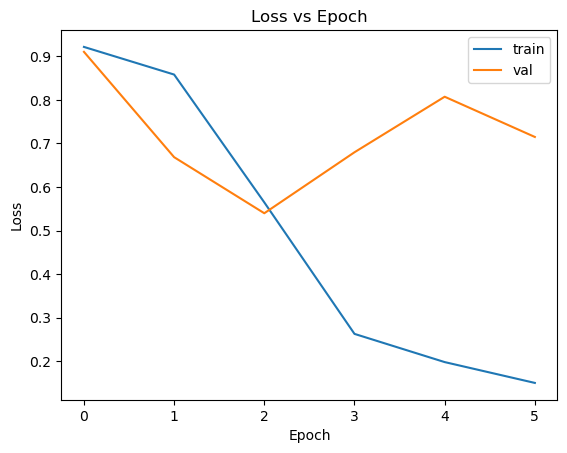

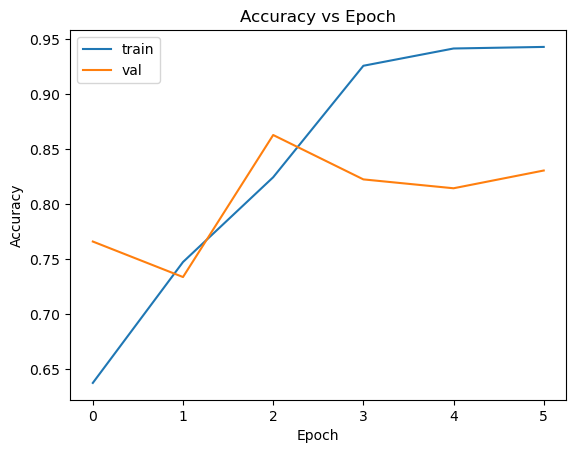

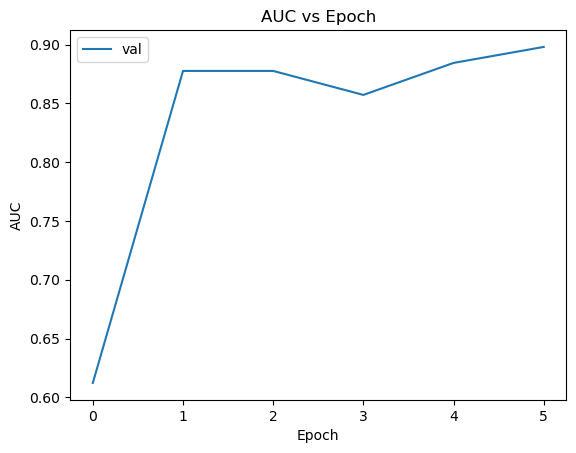

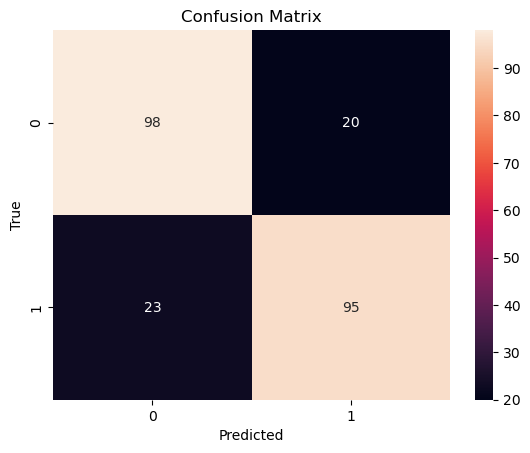

Test AUC: 0.8178
Test Accuracy: 0.8178
Test Recall: 0.8051
Test Precision: 0.8261
Test F1-score: 0.8155


In [15]:
graph(f"{RESULTS_DIR}/{MODEL_NAME}.pkl")